In [125]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image

import cv2
import os
from facenet_pytorch import MTCNN # ?? 
from emotiefflib.facial_analysis import EmotiEffLibRecognizer, get_model_list, EmotiEffLibRecognizerTorch

In [67]:
images_folder = '../data/CityInfant/BlackWhite'

In [68]:
df = pd.read_csv('../data/AU/pyafar_infants.csv')
df = df.iloc[:,[0,1,-2]]
df['imageCat'] = df['imageCat'].map({1: 0, 2: 1, 3: 2})
df.to_csv("../data/CityInfant/Validationinfo/labels.csv", index=False)

In [69]:
image_names = df['Image'].tolist()
affect_labels = df['imageCat'].tolist()


In [70]:
# Split data 

X_train, X_temp, y_train, y_temp = train_test_split(image_names, affect_labels, test_size=0.3, stratify=affect_labels, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(len(X_train))
print(len(X_dev))
print(len(X_test))

105
23
23


In [71]:
# --- 2. Custom Dataset Class ---

class AffectDataset(Dataset):
    def __init__(self, image_names, labels, images_folder, transform=None):
        self.image_names = image_names
        self.labels = labels
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        image_path = os.path.join(self.images_folder, img_name)

        try:
            image = cv2.imread(image_path) # Load image with OpenCV
            if image is None:
                raise ValueError(f"Could not read image at: {image_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert color (if needed)
            image = Image.fromarray(image) #Convert to PIL Image
        except Exception as e:
            print(f"Error loading image: {image_path} - {e}")
            raise  # Re-raise the exception

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [72]:
# Define data transformations
image_size = 224 # Or 260, depending on the EmotiEffLib model
data_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization
])

In [107]:
# Create datasets
train_dataset = AffectDataset(X_train, y_train, images_folder, transform=data_transforms)
dev_dataset = AffectDataset(X_dev, y_dev, images_folder, transform=data_transforms)
test_dataset = AffectDataset(X_test, y_test, images_folder, transform=data_transforms)

# Create DataLoaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last = True)  # Adjust num_workers as needed
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False, num_workers=0, drop_last = False)
test_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False, num_workers=0, drop_last = False)

#### Load pre-trained model #1

In [108]:
model_name = get_model_list()[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(model_name)

enet_b0_8_best_afew


In [109]:
# Load EmotiEffLib recognizer
recognizer = EmotiEffLibRecognizer(model_name=model_name, engine="torch", device=device)

# Access the underlying PyTorch model 
model = recognizer.model

In [110]:
# Fine tune -- modify classifier to our classes 

num_classes = len(np.unique(affect_labels))

in_features = recognizer.classifier_weights.shape[1]

# Replace the classifier with a new linear layer
model.classifier = nn.Linear(in_features, num_classes).to(device)

In [111]:
criterion = nn.CrossEntropyLoss() #Standard cross entropy loss
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
num_epochs = 8

In [112]:
print("Classifier layer before training:", model.classifier.weight[:5])  # Print first few weights


Classifier layer before training: tensor([[-0.0037, -0.0269,  0.0187,  ..., -0.0200, -0.0106, -0.0100],
        [ 0.0039,  0.0215,  0.0270,  ...,  0.0250, -0.0261, -0.0119],
        [-0.0248,  0.0045,  0.0096,  ...,  0.0006,  0.0166, -0.0057]],
       grad_fn=<SliceBackward0>)


In [113]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad() 

        outputs = model(images) #Forward pass
        loss = criterion(outputs, labels) #Calculate the loss
        loss.backward() #Backpropagation
        optimizer.step() #Update weights

        running_loss += loss.item()

        #Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataloader)
    epoch_acc = correct_predictions / total_samples

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

Epoch 1/8, Loss: 1.0480, Accuracy: 0.4583
Epoch 2/8, Loss: 0.8571, Accuracy: 0.7188
Epoch 3/8, Loss: 0.8447, Accuracy: 0.7292
Epoch 4/8, Loss: 0.7169, Accuracy: 0.7500
Epoch 5/8, Loss: 0.6169, Accuracy: 0.8750
Epoch 6/8, Loss: 0.6045, Accuracy: 0.8542
Epoch 7/8, Loss: 0.5024, Accuracy: 0.9375
Epoch 8/8, Loss: 0.4979, Accuracy: 0.9062


In [115]:
print("Classifier layer after training:", model.classifier.weight[:5])


Classifier layer after training: tensor([[ 0.0129, -0.0476,  0.0363,  ..., -0.0079, -0.0219, -0.0023],
        [-0.0133,  0.0112,  0.0105,  ...,  0.0096, -0.0299, -0.0281],
        [-0.0253,  0.0247,  0.0080,  ...,  0.0082,  0.0237,  0.0011]],
       grad_fn=<SliceBackward0>)


In [123]:
torch.save(model.state_dict(), '../models/emotion_2.pth')

In [116]:
def predict(model, dataloader, device):
    model.eval()  
    predictions = []

    with torch.no_grad():
        for i, (images, _) in enumerate(dataloader):
            if images is None or len(images) == 0:
                print(f"Skipping empty batch at index {i}")
                continue  # Skip empty batches

            images = images.to(device)
            print(f"Processing batch {i} with {len(images)} images...")  # Debugging

            outputs = model(images)
            print(f"Raw outputs: {outputs[:5]}")  # Print first 5 outputs

            _, predicted_labels = torch.max(outputs, 1)
            print(f"Predicted labels: {predicted_labels[:5]}")  # Print first 5 predictions
            
            predictions.extend(predicted_labels.cpu().numpy())

    return predictions


In [117]:
print(f"Train dataset size: {len(test_dataset)}")  # Should not be 0

for i, (img, _) in enumerate(test_dataloader):
    print(f"Batch {i}: {len(img)} images") 


Train dataset size: 23
Batch 0: 23 images


In [119]:
test_predictions = predict(model, test_dataloader, device)
test_predictions


Processing batch 0 with 23 images...
Raw outputs: tensor([[ -0.6686,   1.0570,  -0.4282],
        [ -1.9002,  -1.8849,   2.6217],
        [ -0.5250,  -3.4007,   2.8098],
        [ -2.2295, -10.7997,   9.0121],
        [ -0.5130,   0.2419,   0.1265]])
Predicted labels: tensor([1, 2, 2, 2, 1])


[1, 2, 2, 2, 1, 1, 0, 0, 2, 0, 2, 1, 2, 0, 0, 1, 2, 2, 2, 0, 2, 0, 1]

In [120]:
# --- 10. Validation ---
model.eval() #Set the model to evaluation mode

correct_predictions = 0
total_samples = 0

with torch.no_grad(): 
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images) #Forward pass

        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

print('Accuracy: ', correct_predictions/total_samples)


Accuracy:  0.8695652173913043


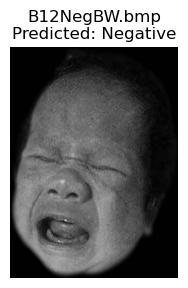

Image: B12NegBW.bmp, Predicted Emotion: Negative


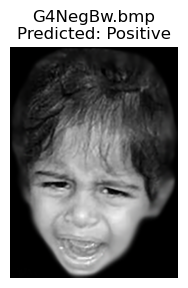

Image: G4NegBw.bmp, Predicted Emotion: Positive


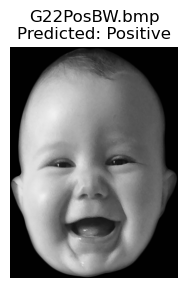

Image: G22PosBW.bmp, Predicted Emotion: Positive


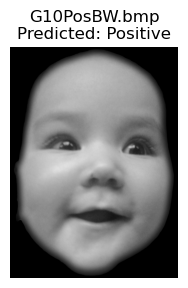

Image: G10PosBW.bmp, Predicted Emotion: Positive


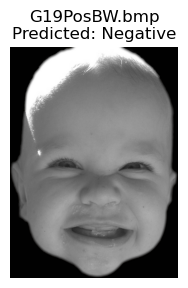

Image: G19PosBW.bmp, Predicted Emotion: Negative


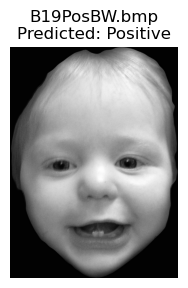

Image: B19PosBW.bmp, Predicted Emotion: Positive


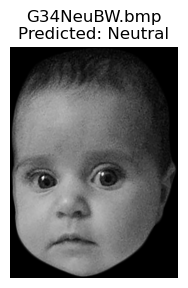

Image: G34NeuBW.bmp, Predicted Emotion: Neutral


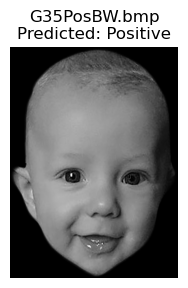

Image: G35PosBW.bmp, Predicted Emotion: Positive


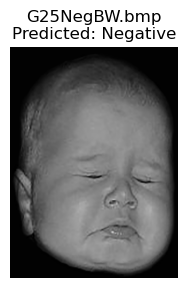

Image: G25NegBW.bmp, Predicted Emotion: Negative


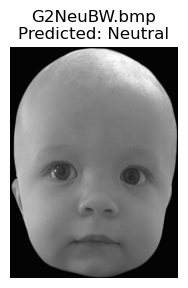

Image: G2NeuBW.bmp, Predicted Emotion: Neutral


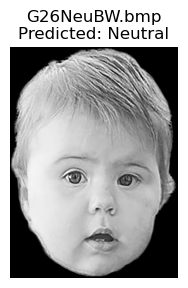

Image: G26NeuBW.bmp, Predicted Emotion: Neutral


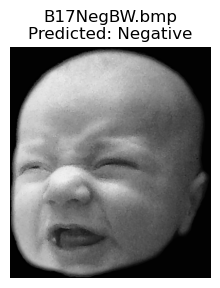

Image: B17NegBW.bmp, Predicted Emotion: Negative


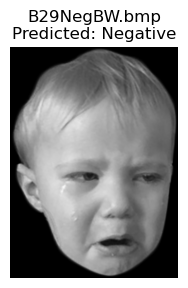

Image: B29NegBW.bmp, Predicted Emotion: Negative


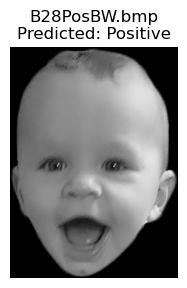

Image: B28PosBW.bmp, Predicted Emotion: Positive


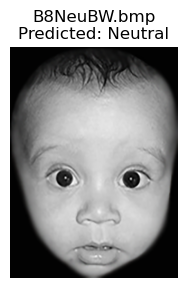

Image: B8NeuBW.bmp, Predicted Emotion: Neutral


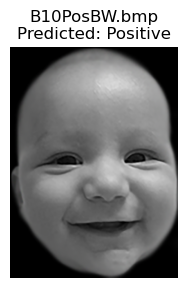

Image: B10PosBW.bmp, Predicted Emotion: Positive


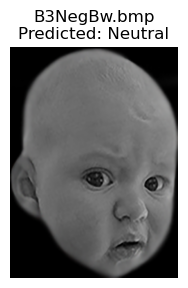

Image: B3NegBw.bmp, Predicted Emotion: Neutral


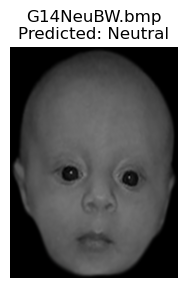

Image: G14NeuBW.bmp, Predicted Emotion: Neutral


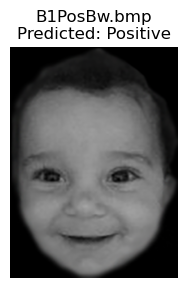

Image: B1PosBw.bmp, Predicted Emotion: Positive


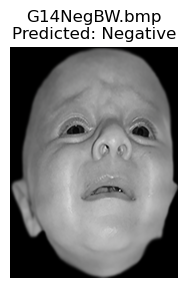

Image: G14NegBW.bmp, Predicted Emotion: Negative


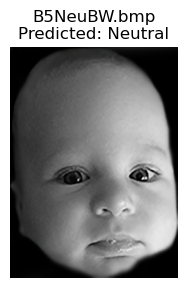

Image: B5NeuBW.bmp, Predicted Emotion: Neutral


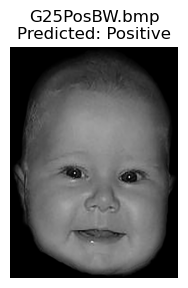

Image: G25PosBW.bmp, Predicted Emotion: Positive


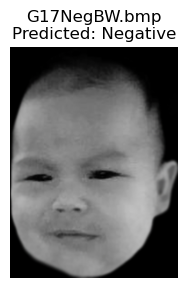

Image: G17NegBW.bmp, Predicted Emotion: Negative


In [127]:
# Load Fine-Tuned Model
model = recognizer.model  # Load original architecture
in_features = recognizer.classifier_weights.shape[1]
num_classes = 3  # Adjust based on your dataset
model.classifier = nn.Linear(in_features, num_classes).to(device)

# Load the fine-tuned weights
model.load_state_dict(torch.load("../models/emotion_2.pth", map_location=device))
model.eval()  # Set model to evaluation mode

# Define image preprocessing (must match training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ensure size matches training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define class labels (adjust based on training labels)
class_labels = {0: "Negative", 1: "Neutral", 2: "Positive"}

# Set test image folder
folder_path = "../data/CityInfant/BlackWhite"

# Loop through test images
for img_name in X_test:
    img_path = os.path.join(folder_path, img_name)

    # Load image with OpenCV
    frame_bgr = cv2.imread(img_path)
    if frame_bgr is None:
        print(f"Image {img_name} not found.")
        continue

    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = Image.fromarray(frame_rgb)  # Convert to PIL Image
    image_tensor = transform(image).unsqueeze(0).to(device)  # Preprocess and add batch dimension

    # Make prediction
    with torch.no_grad():
        output = model(image_tensor)
        predicted_class = torch.argmax(output, dim=1).item()

    predicted_emotion = class_labels[predicted_class]  # Map class to label

    # Display image with emotion label
    plt.figure(figsize=(3, 3))
    plt.axis("off")
    plt.imshow(frame_rgb)
    plt.title(f"{img_name}\nPredicted: {predicted_emotion}")
    plt.show()

    print(f"Image: {img_name}, Predicted Emotion: {predicted_emotion}")
